# Feature Imporatnce Analysis

In [79]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configparser
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from src.utils import utils
from src.modelling import training as train



%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data

In [80]:
proj_root = utils.get_proj_root()
config = configparser.ConfigParser(interpolation=None)
config.read(proj_root.joinpath('config/data_config.ini'))

final_year = int(config['year_limits']['end_year'])
training_data_rel_path = config['data_paths']['preprocessed_data_path']

training_data_path =  proj_root.joinpath(training_data_rel_path)
training_data_subset_path  = proj_root.joinpath(config['data_paths']['training_subset_path'])
testing_data_subset_path  = proj_root.joinpath(config['data_paths']['testing_subset_path'])

In [3]:

train_data =  pd.read_csv(training_data_subset_path)
test_data = pd.read_csv(testing_data_subset_path)
train_data.head()

,year,industry,symbol,currentRatio,currentRatio_percentage_change,quickRatio,quickRatio_percentage_change,daysOfSalesOutstanding,daysOfSalesOutstanding_percentage_change,daysOfInventoryOutstanding,...,priceEarningsToGrowthRatio_percentage_change,dividendYield,dividendYield_percentage_change,enterpriseValueMultiple,enterpriseValueMultiple_percentage_change,interestRate,interestRate_percentage_change,adjDividend,dps_growth,dps_change_next_year
0,2012,24,291,2.198387,-2.275946,1.385806,-0.090461,49.567449,3.987852,89.289449,...,6.939145,0.025377,-5.500411,8.692139,5.900833,0.14,40.000000,2.36,7.272727,0
1,2013,24,291,1.698186,-22.753086,1.012270,-26.954450,50.284895,1.447414,87.567366,...,21.913077,0.018089,-28.717392,12.326051,41.806877,0.11,-21.428571,2.54,7.627119,0
2,2014,24,291,1.961487,15.504836,1.127209,11.354593,48.611609,-3.327613,82.245394,...,-39.851336,0.020773,14.836058,13.065263,5.997151,0.09,-18.181818,3.42,34.645669,0
3,2015,24,291,1.543411,-21.314241,0.852768,-24.346986,50.082909,3.026645,83.473315,...,799.567847,0.027175,30.819267,12.318266,-5.717433,0.13,44.444444,4.10,19.883041,0
4,2016,24,291,1.885512,22.165260,1.136839,33.311664,53.242552,6.308824,82.149269,...,-84.149916,0.024801,-8.738086,13.479738,9.428861,0.40,207.692308,4.44,8.292683,0


In [4]:
test_data.head()

,year,industry,symbol,currentRatio,currentRatio_percentage_change,quickRatio,quickRatio_percentage_change,daysOfSalesOutstanding,daysOfSalesOutstanding_percentage_change,daysOfInventoryOutstanding,...,priceEarningsToGrowthRatio_percentage_change,dividendYield,dividendYield_percentage_change,enterpriseValueMultiple,enterpriseValueMultiple_percentage_change,interestRate,interestRate_percentage_change,adjDividend,dps_growth,dps_change_next_year
0,2021,24,291,1.704815,-9.559027,1.043165,-14.902195,48.109178,-9.839675,96.808992,...,67.702091,0.033253,-0.909598,15.729376,-12.979421,0.08,-78.947368,5.92,0.680272,0
1,2021,96,36,1.566500,-14.191051,1.131391,-21.328131,65.431631,-11.277742,73.344031,...,-112.480300,0.012391,-30.862468,19.078414,21.967224,0.08,-78.947368,1.06,8.163265,0
2,2021,63,4,1.849599,7.740228,1.277070,12.122625,54.968195,-18.741994,101.543130,...,-69.722616,0.012897,-2.300018,23.954222,-12.035499,0.08,-78.947368,1.80,25.000000,0
3,2021,31,3,0.793544,-5.912486,0.562795,-6.766883,64.800701,-7.822868,65.443082,...,-118.942510,0.038643,-10.545641,11.593723,-68.566197,0.08,-78.947368,5.20,10.169492,0
4,2021,49,6,1.251937,-10.687424,1.139527,-11.782243,70.266362,8.749094,0.000000,...,-45.271038,0.010467,-21.579906,21.516834,24.968678,0.08,-78.947368,3.61,10.060976,0


In [5]:
label_col_name = 'dps_change_next_year'
X_train, y_train = train.split_Xy(train_data, label_col_name=label_col_name)
X_test, y_test = train.split_Xy(test_data, label_col_name=label_col_name)

# Feature Importance

## check feature importance

In [6]:


randomForestModel = RandomForestClassifier(max_features=None)  # We want all features to be considered for each tree



randomForestModel.fit(X_train, y_train)
model_importance = randomForestModel.feature_importances_
importance_table = pd.DataFrame(columns=["Feature", "Importance"])  # Create an importance table to plot bar chart
featureNum = 0
for score in model_importance:
    # print("feature " + str(featureNum) + "'s importance score: " + str(score) + " (" + X_train.columns[featureNum] + ")")
    rowAdded = pd.DataFrame([[X_train.columns[featureNum], score]], columns=["Feature", "Importance"])
    importance_table = pd.concat([importance_table, rowAdded])
    featureNum = featureNum + 1
importance_table_sorted =  importance_table.sort_values('Importance', ascending=False).reset_index(drop=True)




/tmp/ipykernel_319/3311707507.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  importance_table = pd.concat([importance_table, rowAdded])


In [14]:

importance_table_sorted =  importance_table.sort_values('Importance', ascending=False).reset_index(drop=True)
importance_table_sorted

,Feature,Importance
0,dps_growth,0.224128
1,dividendYield,0.125708
2,interestRate,0.074270
3,adjDividend,0.065153
4,interestRate_percentage_change,0.041588
...,...,...
83,priceEarningsRatio_percentage_change,0.002163
84,quickRatio_percentage_change,0.002132
85,operatingCashFlowPerShare_percentage_change,0.002103
86,receivablesTurnover_percentage_change,0.001979


In [67]:

feature_importance_path = proj_root.joinpath(config['modelling_paths']['feature_importance'])
importance_table_sorted.to_csv(feature_importance_path, index=False)

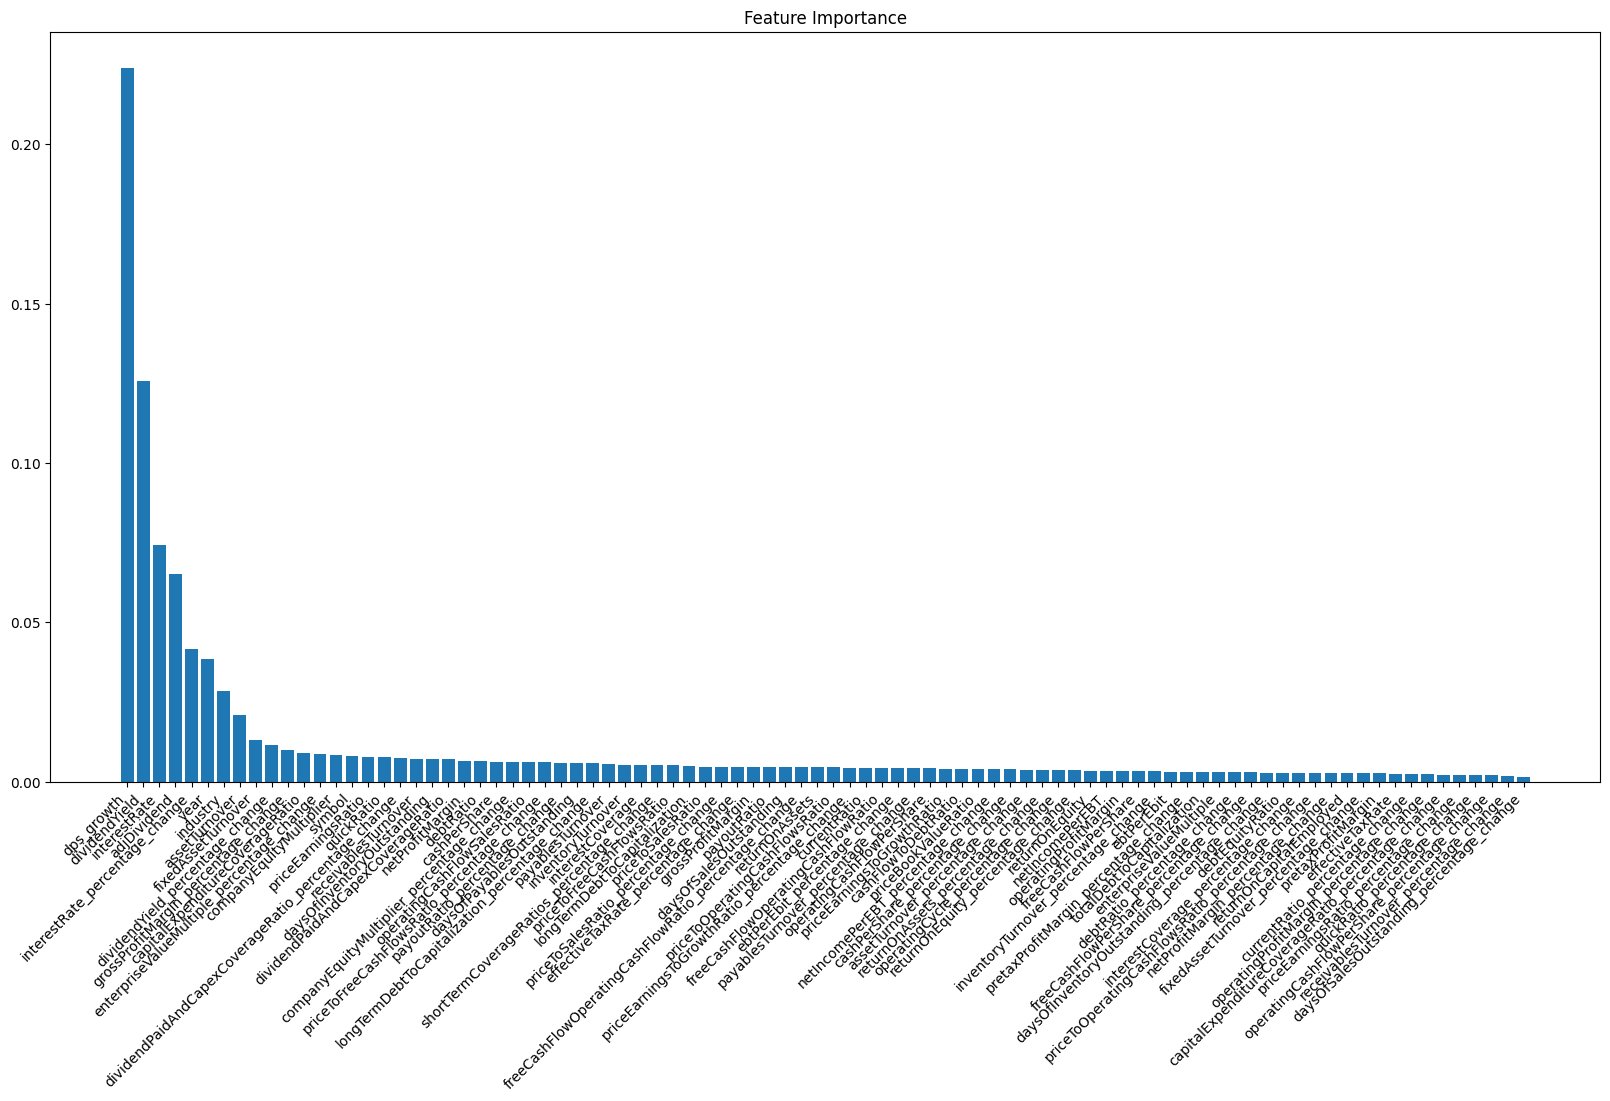

In [18]:
# Plot a bar chart to visualize feature importance
plt.figure(figsize=(20, 10))
# sns.barplot(data=importance_table, x="Feature", y="Importance")
plt.bar(importance_table_sorted['Feature'], importance_table_sorted['Importance'])
plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=45, ha='right')
plt.show()

## Check model performance with feature importance

In [19]:
X_train_temp = X_train.copy()
X_test_temp = X_test.copy()

# Initialize the result dataframe
result_df = pd.DataFrame(columns=['Features_Removed', 'ROC_Score'])

# First, evaluate performance using all features
randomForestModel = RandomForestClassifier(max_features=None)
randomForestModel.fit(X_train_temp, y_train)
# Predict probabilities on test data
y_pred_probs = randomForestModel.predict_proba(X_test_temp)[:, 1]
# Compute ROC score
roc_score = roc_auc_score(y_test, y_pred_probs)
# Append the initial result to the result dataframe
new_row = pd.DataFrame({'Features_Removed': ['None'], 'ROC_Score': [roc_score]})
result_df = pd.concat([result_df, new_row])
# result_df = result_df.append({'Features_Removed': 'None', 'ROC_Score': roc_score}, ignore_index=True)
print(f"Feature_Removed: None, Number of features used: {len(X_train_temp.columns)}, ROC_AUC_Score: {roc_score}")

# Sort importance_table by Importance in ascending order to start with the least important
importance_table_sorted_asc = importance_table.sort_values('Importance', ascending=True)

# Loop through features, starting from the least important
for index, row in importance_table_sorted_asc.iterrows():
    # Drop the feature from training and test data
    X_train_temp = X_train_temp.drop(columns=[row['Feature']])
    X_test_temp = X_test_temp.drop(columns=[row['Feature']])
    # Train a random forest model
    randomForestModel = RandomForestClassifier(max_features=None)
    randomForestModel.fit(X_train_temp, y_train)
    # Predict probabilities on test data
    y_pred_probs = randomForestModel.predict_proba(X_test_temp)[:, 1]
    # Compute ROC score
    roc_score = roc_auc_score(y_test, y_pred_probs)
    # Append the result to the result dataframe
    new_row = pd.DataFrame({'Features_Removed': [row['Feature']], 'ROC_Score': [roc_score]})
    result_df = pd.concat([result_df, new_row])
    # result_df = result_df.append({'Features_Removed': row['Feature'], 'ROC_Score': roc_score}, ignore_index=True)
    print(
        f"Feature_Removed: {row['Feature']}, Number of features used: {len(X_train_temp.columns)}, ROC_AUC_Score: {roc_score}")
    # If only one feature left, break the loop
    if X_train_temp.shape[1] == 1:
        break

/tmp/ipykernel_319/2520037336.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, new_row])


Feature_Removed: None, Number of features used: 88, ROC_AUC_Score: 0.8613880742913
Feature_Removed: daysOfSalesOutstanding_percentage_change, Number of features used: 87, ROC_AUC_Score: 0.8434017595307919
Feature_Removed: receivablesTurnover_percentage_change, Number of features used: 86, ROC_AUC_Score: 0.8724340175953079
Feature_Removed: operatingCashFlowPerShare_percentage_change, Number of features used: 85, ROC_AUC_Score: 0.8307917888563049
Feature_Removed: quickRatio_percentage_change, Number of features used: 84, ROC_AUC_Score: 0.8635386119257086
Feature_Removed: priceEarningsRatio_percentage_change, Number of features used: 83, ROC_AUC_Score: 0.8643206256109482
Feature_Removed: capitalExpenditureCoverageRatio_percentage_change, Number of features used: 82, ROC_AUC_Score: 0.864711632453568
Feature_Removed: operatingProfitMargin_percentage_change, Number of features used: 81, ROC_AUC_Score: 0.8360703812316714
Feature_Removed: currentRatio_percentage_change, Number of features used

In [68]:
result_df.reset_index(inplace=True, drop=True)
model_performance_with_feature_drop_path = proj_root.joinpath(config['modelling_paths']['model_performance_with_feature_drop'])
result_df.to_csv(model_performance_with_feature_drop_path, index=False)

In [81]:
# result_df[result_df.index==result_df['ROC_Score'].argmax()]['Features_Removed'].values[0]

feature_removed_before_max_score = result_df.iloc[result_df['ROC_Score'].argmax(), :]['Features_Removed']

feature_rank_thresh = importance_table_sorted.index[importance_table_sorted['Feature'] == feature_removed_before_max_score][0]

max_score_features = list(importance_table_sorted[importance_table_sorted.index < feature_rank_thresh]['Feature'].values)

max_score_features



utils.save_value(value=max_score_features, fname=proj_root.joinpath(config['modelling_paths']['optimal_features']))

In [83]:
utils.load_value(fname=proj_root.joinpath(config['modelling_paths']['optimal_features']))

['dps_growth',
 'dividendYield',
 'interestRate',
 'adjDividend',
 'interestRate_percentage_change']

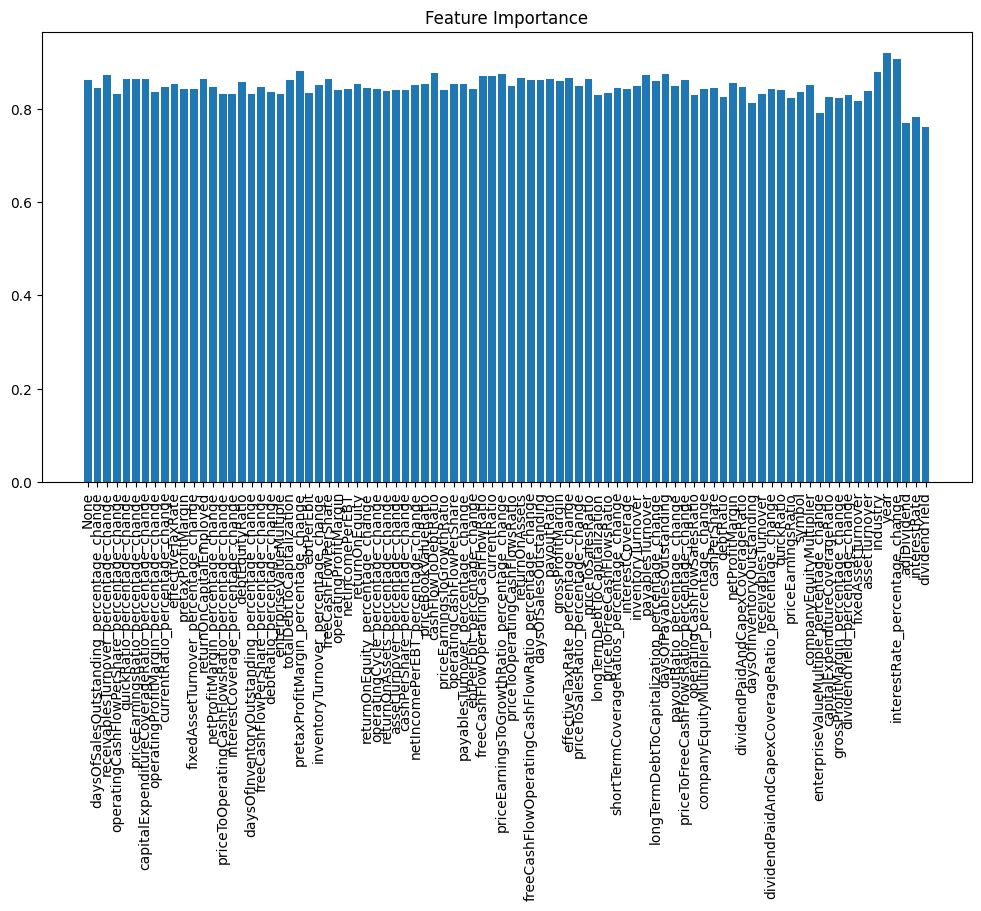

In [91]:
result_df

fig, ax = plt.subplots(figsize=(12, 6))
# plt.close()

ax.bar(result_df['Features_Removed'], result_df['ROC_Score'])

plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=90,  )
plt.show()